In [1]:
%pylab inline
# For data importing
import pandas as pd
# For machine learning
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
# For plotting
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
random_state = np.random.RandomState(1289237)  #我们在本教程中固定numpy的随机种子，以使结果可重现
X, y = make_classification(n_samples=1000, n_classes=2, n_features=4,
                           n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           class_sep=0.9, random_state=random_state)
X.shape, y.shape #查看特征和标签的shape

((1000, 4), (1000,))

In [13]:
X

array([[ 1.1589473 ,  0.77221238, -0.85857696,  0.67265834],
       [-0.98090181, -0.71858291, -2.30005697,  0.60363342],
       [ 0.01261987,  1.71153561,  0.69556838, -0.27678105],
       ...,
       [ 0.53912919,  0.23116799, -1.99669273,  0.06056901],
       [-2.14218584,  0.50002644,  0.46631921,  0.43349694],
       [ 0.30068623,  0.61176064, -0.24807181,  1.52864913]])

In [4]:
X

array([[ 1.20208996, -0.08910427, -1.11576995,  0.66218976],
       [-0.93205879, -1.59357499, -2.91424455,  0.59468278],
       [ 0.05881623,  0.85883561,  0.82327248, -0.26637041],
       ...,
       [ 0.58392299, -0.63511179, -2.53574963,  0.06356095],
       [-2.09024926, -0.36378703,  0.53724784,  0.42828778],
       [ 0.34611522, -0.25102786, -0.35406809,  1.49935637]])

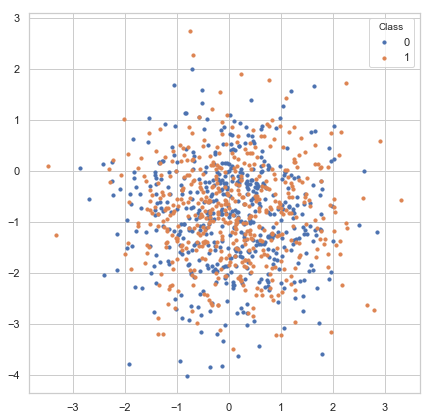

In [3]:
fig, ax = plt.subplots(figsize=(7, 7))
for label in np.unique(y):
    ax.scatter(X[y == label, 0], X[y == label, 1], s=10, label=str(label))
ax.legend(title='Class')

In [6]:
X = StandardScaler().fit_transform(X)

/apps/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'scaled data distribution by standard scaling')

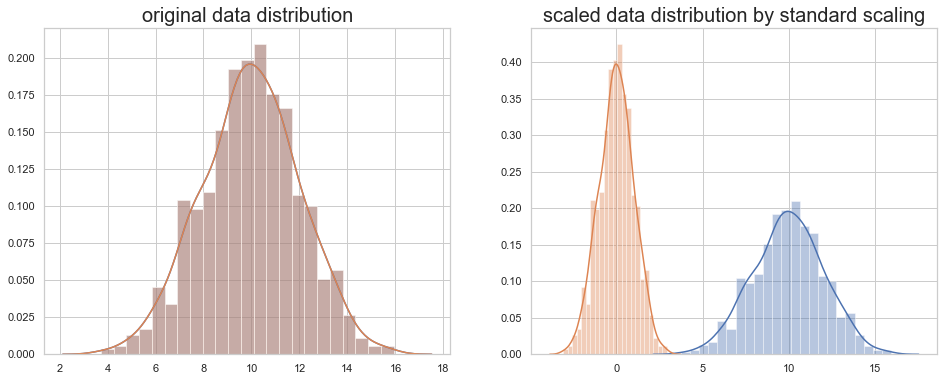

In [7]:
#产生模拟数据，1000个数据点，均值为10，标准差为2
random_state = np.random.RandomState(1289237)
x = random_state.normal(10, 2, size=1000)
fig, ax = plt.subplots(1,2,figsize=(16, 6))
sns.distplot(x, ax=ax[0])
sns.distplot(x, ax=ax[1])
sns.distplot(np.ravel(x), ax=ax[0])
sns.distplot(np.ravel(StandardScaler().fit_transform(x.reshape((-1, 1)))), ax=ax[1])
ax[0].set_title('original data distribution',fontsize=20)
ax[1].set_title('scaled data distribution by standard scaling',fontsize=20)

In [8]:
random_state = np.random.RandomState(1289237)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))

number of training samples: 800, test samples: 200


In [9]:
model = LogisticRegression()
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Text(0.5, 0, 'Sample')

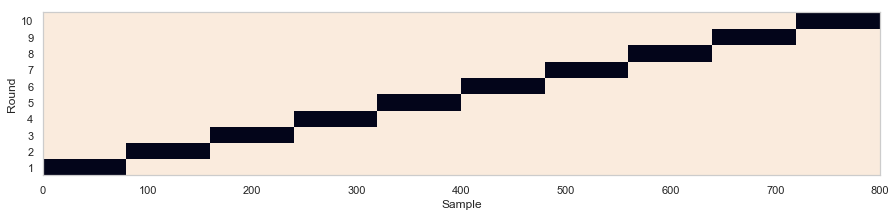

In [10]:
n_splits = 10

kfold = KFold(n_splits=n_splits, random_state=random_state)
is_train = np.zeros((n_splits, X_train.shape[0]), dtype=np.bool)
for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    is_train[i, train_index] = 1

fig, ax = plt.subplots(figsize=(15, 3))
ax.pcolormesh(is_train)
ax.set_yticks(np.arange(n_splits) + 0.5)
ax.set_yticklabels(np.arange(n_splits) + 1)
ax.set_ylabel('Round')
ax.set_xlabel('Sample')

In [11]:
predictions = np.zeros((n_splits, X_train.shape[0]), dtype=np.int32)
predicted_scores = np.zeros((n_splits, X_train.shape[0]))

for i in range(n_splits):
    model.fit(X_train[is_train[i]], y_train[is_train[i]])
    predictions[i] = model.predict(X_train)
    predicted_scores[i] = model.predict_proba(X_train)[:, 1]

In [12]:
scorers = {'accuracy': accuracy_score,
           'recall': recall_score,
           'precision': precision_score,
           'f1': f1_score,
           'mcc': matthews_corrcoef
}
cv_metrics = pd.DataFrame(np.zeros((n_splits*2, len(scorers) + 2)),
                          columns=list(scorers.keys()) + ['roc_auc', 'average_precision'])
cv_metrics.loc[:, 'dataset'] = np.empty(n_splits*2, dtype='U')
for i in range(n_splits):
    for metric in scorers.keys():
        cv_metrics.loc[i*2 + 0, metric] = scorers[metric](y_train[is_train[i]], predictions[i, is_train[i]])
        cv_metrics.loc[i*2 + 1, metric] = scorers[metric](y_train[~is_train[i]], predictions[i, ~is_train[i]])
    cv_metrics.loc[i*2 + 0, 'roc_auc'] = roc_auc_score(y_train[is_train[i]], predicted_scores[i, is_train[i]])
    cv_metrics.loc[i*2 + 1, 'roc_auc'] = roc_auc_score(y_train[~is_train[i]], predicted_scores[i, ~is_train[i]])
    cv_metrics.loc[i*2 + 0, 'average_precision'] = average_precision_score(y_train[is_train[i]], 
                                                                           predicted_scores[i, is_train[i]])
    cv_metrics.loc[i*2 + 1, 'average_precision'] = average_precision_score(y_train[~is_train[i]], 
                                                                           predicted_scores[i, ~is_train[i]])
    cv_metrics.loc[i*2 + 0, 'dataset'] = 'train'
    cv_metrics.loc[i*2 + 1, 'dataset'] = 'valid'

cv_metrics

,accuracy,recall,precision,f1,mcc,roc_auc,average_precision,dataset
0,0.883333,0.907609,0.869792,0.888298,0.767081,0.944641,0.936965,train
1,0.837500,0.894737,0.790698,0.839506,0.681520,0.897870,0.810110,valid
2,0.873611,0.901370,0.856771,0.878505,0.748032,0.936600,0.912893,train
3,0.925000,0.951220,0.906977,0.928571,0.850786,0.972483,0.973525,valid
4,0.869444,0.898352,0.851562,0.874332,0.739840,0.935370,0.912378,train
5,0.962500,0.952381,0.975610,0.963855,0.925196,0.981830,0.979835,valid
6,0.876389,0.907162,0.863636,0.884864,0.752664,0.934445,0.915088,train
7,0.900000,0.896552,0.838710,0.866667,0.787929,0.977688,0.960846,valid
8,0.879167,0.910811,0.861893,0.885677,0.759053,0.940394,0.919333,train
9,0.850000,0.861111,0.815789,0.837838,0.699376,0.935606,0.919198,valid
